## Analyse des clients du site d'e-commerce Olist

In [147]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import datetime
import random
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import intercluster_distance
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
from kmodes.kprototypes import KPrototypes
import gc

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

In [148]:
sns.set_palette("Pastel2")

In [149]:
%pwd

'/Users/anissa/archive'

In [150]:
%cd /Users/anissa/archive

/Users/anissa/archive


### 1. Création d'une segmentation RFM

On débute l'analyse de notre base de clients par la création d'une segmentation RFM (Recency, Frequency, MonetaryValue). Ce type de segmentation est utilisé en marketing pour pouvoir découper les clients en segments actionnables et ainsi adapter les stratégies en fonction du type de client. La segmentation RFM se base sur des habitudes de consommations comme la date du dernier achat (Recency), la fréquence d'achat (Frequency) et la valeur moyenne/la somme moyenne dépensée lors d'une commande (MonetaryValue).

#### a. Informations sur les clients

On va commencer par extraire les informations clients pour pouvoir déterminer les premières variables de notre segmentation.

In [151]:
df_customers = pd.read_csv("olist_customers_dataset.csv")
df_geo = pd.read_csv("olist_geolocation_dataset.csv")

In [152]:
# Add geolocation information
df_customers = pd.merge(df_geo, df_customers,
                        right_on=["customer_zip_code_prefix",
                                  "customer_city", "customer_state"],
                        left_on=["geolocation_zip_code_prefix",
                                 "geolocation_city", "geolocation_state"],
                        how="right")
df_customers.drop(["geolocation_zip_code_prefix", "geolocation_city",
                   "geolocation_state"], axis=1, inplace=True)
df_customers = df_customers[["customer_id", "customer_unique_id",
                             "customer_city", "geolocation_lat",
                             "geolocation_lng"]]
df_customers.columns = ["customer_id", "customer_unique_id",
                        "customer_city", "customer_latitude",
                        "customer_longitude"]
df_customers.head()

,customer_id,customer_unique_id,customer_city,customer_latitude,customer_longitude
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,-20.509897,-47.397866
1,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,-20.497396,-47.399241
2,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,-20.510459,-47.399553
3,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,-20.480940,-47.394161
4,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,-20.515413,-47.398194


In [153]:
df_customers.drop_duplicates(subset="customer_unique_id", 
                             inplace=True)

In [154]:
print("Nombre d'id unique:", df_customers["customer_unique_id"].nunique())

Nombre d'id unique: 96096


In [155]:
print("Nombre d'id clients:", df_customers["customer_id"].nunique())

Nombre d'id clients: 96096


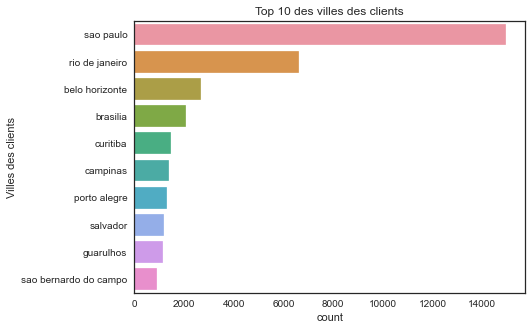

In [156]:
plt.figure(figsize=(7,5))
sns.countplot(y="customer_city", data=df_customers, order=df_customers["customer_city"].value_counts().index[:10])
plt.title("Top 10 des villes des clients")
plt.ylabel("Villes des clients")
plt.show()

La majorité des clients vivent à Rio de Janeiro. Il s'agit de la seconde ville la plus peuplée du Brésil. Elle possède 8% de la population du pays. On observe qu'ensuite les clients vivent à Sao Paolo, qui est la ville la plus peuplée du pays. Enfin, en troisième position, on retrouve Belo Horizonte. Cette ville se situe dans l'état de Minas Gerais.

In [157]:
print("Nombre de villes:", df_customers["customer_city"].nunique())

Nombre de villes: 4118


Les clients se répartissent dans 4118 villes. Le Brésil compte 5570 villes.

#### b. Informations sur les commandes

On va ensuite s'intéresser aux informations des commandes pour calculer

In [158]:
df_orders = pd.read_csv("olist_orders_dataset.csv")
df_orders_payments = pd.read_csv("olist_order_payments_dataset.csv")
df_review = pd.read_csv("olist_order_reviews_dataset.csv")
df_order_items = pd.read_csv("olist_order_items_dataset.csv")

In [159]:
df_orders = pd.merge(df_orders, df_orders_payments, on ="order_id", how="left")
df_orders = pd.merge(df_orders, df_review, on="order_id", how="left")
df_orders = pd.merge(df_orders, df_order_items, on="order_id", how="left")
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,...,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,credit_card,...,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,3.0,voucher,...,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2.0,voucher,...,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1.0,boleto,...,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1.0,credit_card,...,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22


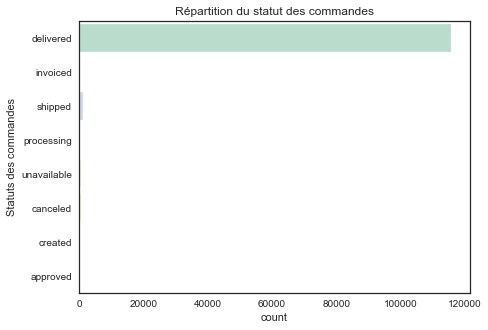

In [160]:
plt.figure(figsize=(7, 5))
sns.countplot(y="order_status", data=df_orders)
plt.title("Répartition du statut des commandes")
plt.ylabel("Statuts des commandes")
plt.show()

La plupart des commandes sont au statut "Réceptionné".

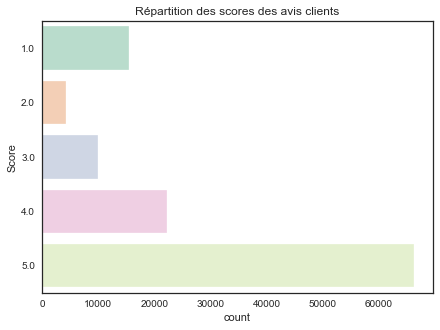

In [161]:
plt.figure(figsize=(7, 5))
sns.countplot(y="review_score", data=df_orders)
plt.title("Répartition des scores des avis clients")
plt.ylabel("Score")
plt.show()

La majorité des clients a attribué la note maximale à leurs commandes (5). Il y a peu d'avis négatif.

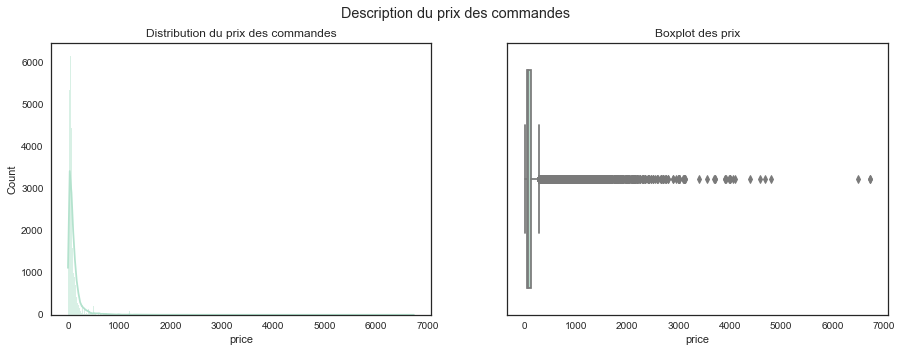

In [162]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Description du prix des commandes')

sns.histplot(ax=axes[0],x="price", data=df_orders, kde=True)
axes[0].set_title("Distribution du prix des commandes")

sns.boxplot(ax=axes[1], x="price", data=df_orders)
axes[1].set_title("Boxplot des prix")

plt.show()

Les commandes sont comprises entre 0 et 7000 Réaux brésiliens. Le prix des commandes ne semblent pas suivre une loi normale.

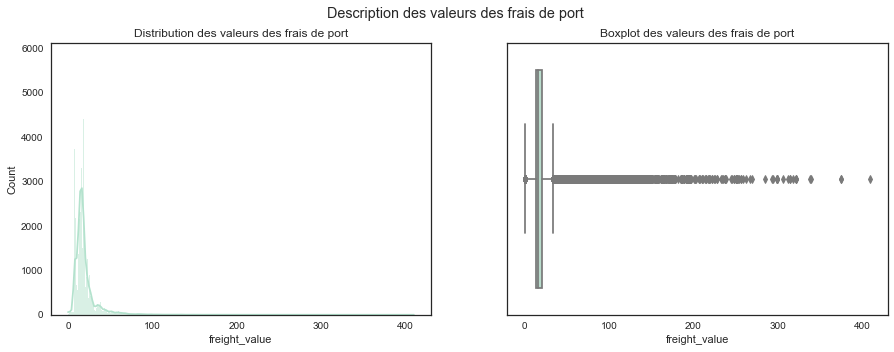

In [163]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Description des valeurs des frais de port')

sns.histplot(ax=axes[0],x="freight_value", data=df_orders, kde=True)
axes[0].set_title("Distribution des valeurs des frais de port")

sns.boxplot(ax=axes[1], x="freight_value", data=df_orders)
axes[1].set_title("Boxplot des valeurs des frais de port")

plt.show()

La valeur des frais de port ne suit pas une loi normale. Les frais de port sont compris entre 0 et 400 Réaux brésiliens.

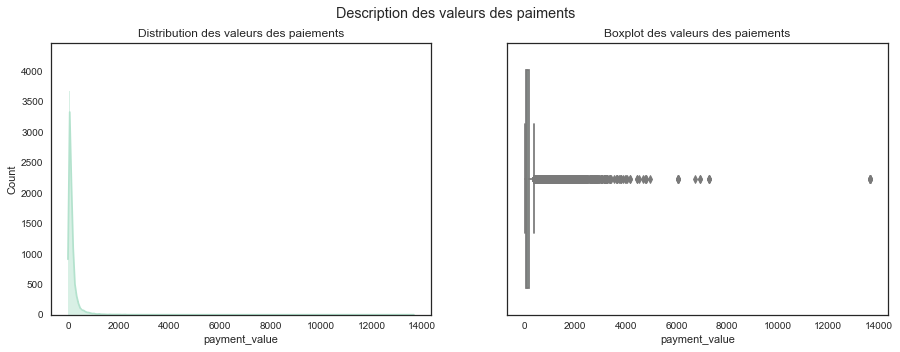

In [164]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Description des valeurs des paiments')

sns.histplot(ax=axes[0],x="payment_value", data=df_orders, kde=True)
axes[0].set_title("Distribution des valeurs des paiements")

sns.boxplot(ax=axes[1], x="payment_value", data=df_orders)
axes[1].set_title("Boxplot des valeurs des paiements")

plt.show()

La valeur maximale des paiements est de 14 000 Réaux brésiliens.

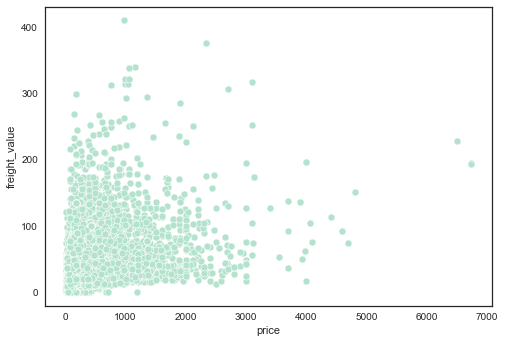

In [165]:
sns.scatterplot(x="price", y="freight_value", data=df_orders)
plt.show()

Il ne semble pas avoir de lien entre les prix des commandes et les frais de port.

In [166]:
df_products = pd.read_csv("olist_products_dataset.csv")
df_translation = pd.read_csv('product_category_name_translation.csv')

df_products = pd.merge(df_products, df_translation, on="product_category_name")
df_products.drop("product_category_name", axis=1, inplace=True)
df_products.head()

,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,6a2fb4dd53d2cdb88e0432f1284a004c,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery
2,0d009643171aee696f4733340bc2fdd0,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery
3,b1eae565a61935e0011ee7682fef9dc9,49.0,460.0,2.0,267.0,17.0,13.0,17.0,perfumery
4,8da90b37f0fb171b4877c124f965b1f6,56.0,733.0,3.0,377.0,18.0,13.0,15.0,perfumery


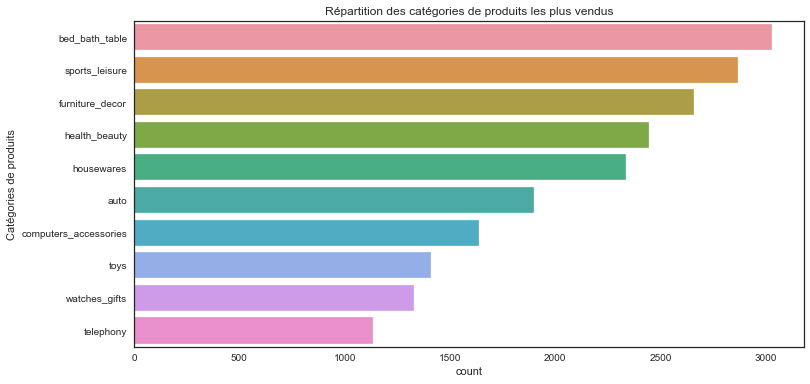

In [167]:
plt.figure(figsize=(12, 6))
sns.countplot(y="product_category_name_english", data=df_products, 
             order=df_products["product_category_name_english"].value_counts().index[:10])
plt.ylabel("Catégories de produits")
plt.title("Répartition des catégories de produits les plus vendus")
plt.show()

La catégorie la plus vendue est le linge de maison, suivie par les sports et loisirs et la décoration.

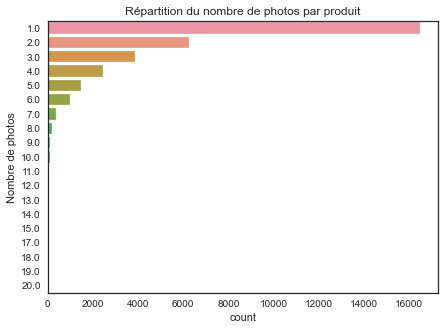

In [168]:
plt.figure(figsize=(7, 5))
sns.countplot(y="product_photos_qty", data=df_products)
plt.ylabel("Nombre de photos")
plt.title("Répartition du nombre de photos par produit")
plt.show()

En général, chaque produit est accompagné par une photo. Certains produits ont jusqu'à 11 photos.

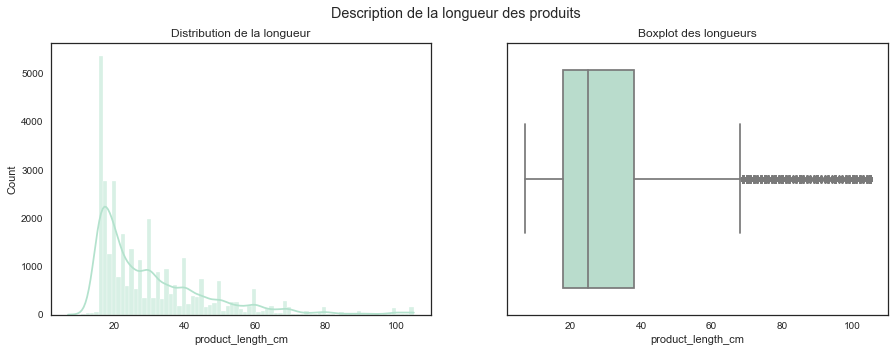

In [169]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Description de la longueur des produits')

sns.histplot(ax=axes[0],x="product_length_cm", data=df_products, kde=True)
axes[0].set_title("Distribution de la longueur")

sns.boxplot(ax=axes[1], x="product_length_cm", data=df_products)
axes[1].set_title("Boxplot des longueurs")

plt.show()

La longueur des produits est comprise entre 0 et un peu plus de 100 cm. La majorité des produits a une longueur d'environ 20 cm.

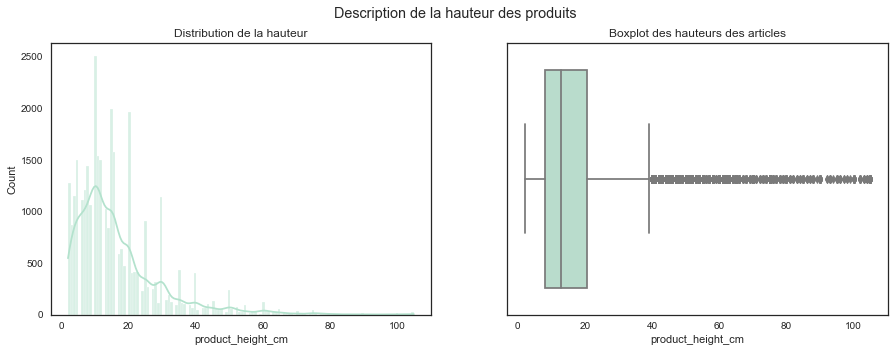

In [170]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Description de la hauteur des produits')

sns.histplot(ax=axes[0],x="product_height_cm", data=df_products, kde=True)
axes[0].set_title("Distribution de la hauteur")

sns.boxplot(ax=axes[1], x="product_height_cm", data=df_products)
axes[1].set_title("Boxplot des hauteurs des articles")

plt.show()

La hauteur des produit se situe entre 0 et un peu plus de 100 cm. La hauteur moyenne est comprise entre 15 et 20 cm.

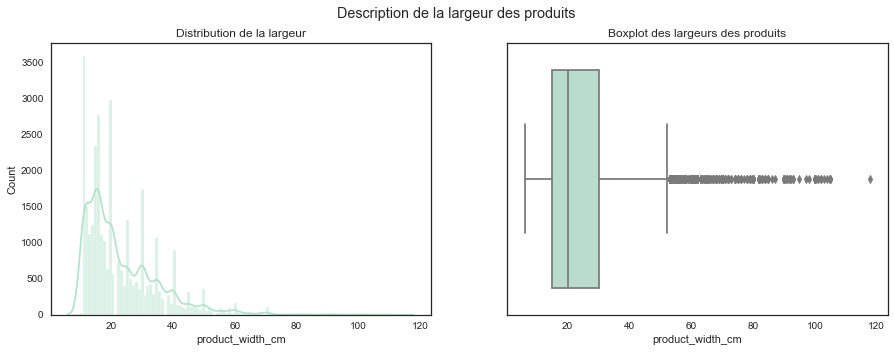

In [171]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Description de la largeur des produits')

sns.histplot(ax=axes[0],x="product_width_cm", data=df_products, kde=True)
axes[0].set_title("Distribution de la largeur")

sns.boxplot(ax=axes[1], x="product_width_cm", data=df_products)
axes[1].set_title("Boxplot des largeurs des produits")

plt.show()

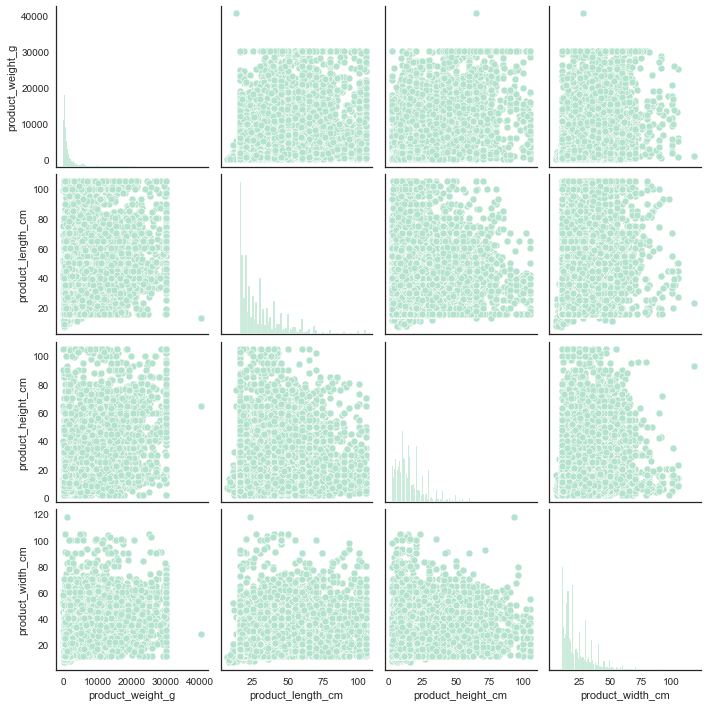

In [172]:
sns.pairplot(df_products[['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']])
plt.show()

In [173]:
df_prod_orders = pd.merge(df_products, df_orders, on="product_id", how="left")
df_prod_orders.head()

,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,order_id,...,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,seller_id,shipping_limit_date,price,freight_value
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery,e17e4f88e31525f7deef66779844ddce,...,5.0,Vale a pena,Super adooorei o delineador ele é bem preto e ...,2018-04-28 00:00:00,2018-05-04 00:55:02,1.0,5670f4db5b62c43d542e1b2d56b0cf7c,2018-04-30 17:33:54,10.91,7.39
1,6a2fb4dd53d2cdb88e0432f1284a004c,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery,5fa78e91b5cb84b6a8ccc42733f95742,...,2.0,NaN,NaN,2017-12-14 00:00:00,2017-12-17 02:57:05,1.0,7040e82f899a04d1b434b795a43b4617,2017-12-14 16:33:14,16.90,7.78
2,6a2fb4dd53d2cdb88e0432f1284a004c,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery,048cc42e03ca8d43c729adf6962cb348,...,5.0,NaN,O produto que chegou é mais bonito do que eu e...,2017-11-24 00:00:00,2017-11-24 18:34:45,1.0,7040e82f899a04d1b434b795a43b4617,2017-11-23 21:31:31,16.90,7.78
3,0d009643171aee696f4733340bc2fdd0,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery,a84a0bd528e053f6b266e21bb1111e3f,...,5.0,Muito bom !!,Recomendo tanto o site lannister quanto a loja...,2018-07-11 00:00:00,2018-07-11 10:06:10,1.0,620c87c171fb2a6dd6e8bb4dec959fc6,2018-07-09 20:31:35,319.90,15.45
4,0d009643171aee696f4733340bc2fdd0,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery,24b1c4d88fdb7a2dc87f8ecc7d8f47f1,...,5.0,NaN,ótimo produto e ótima loja para comprar pelo s...,2017-08-09 00:00:00,2017-08-09 19:30:09,1.0,fe2032dab1a61af8794248c8196565c9,2017-08-03 09:50:14,339.00,17.13


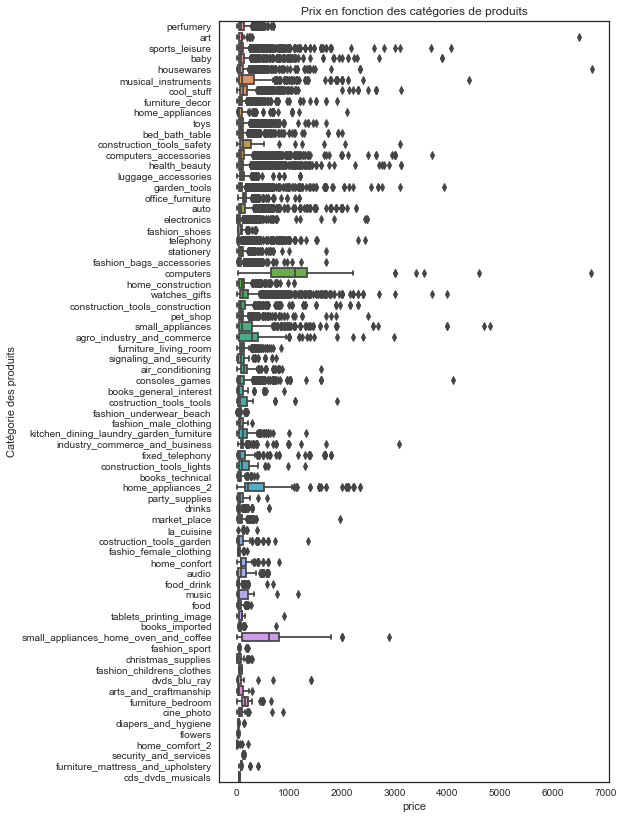

In [174]:
plt.figure(figsize=(7, 14))
sns.boxplot(x="price", y="product_category_name_english", data=df_prod_orders)
plt.ylabel("Catégorie des produits")
plt.title("Prix en fonction des catégories de produits")
plt.show()

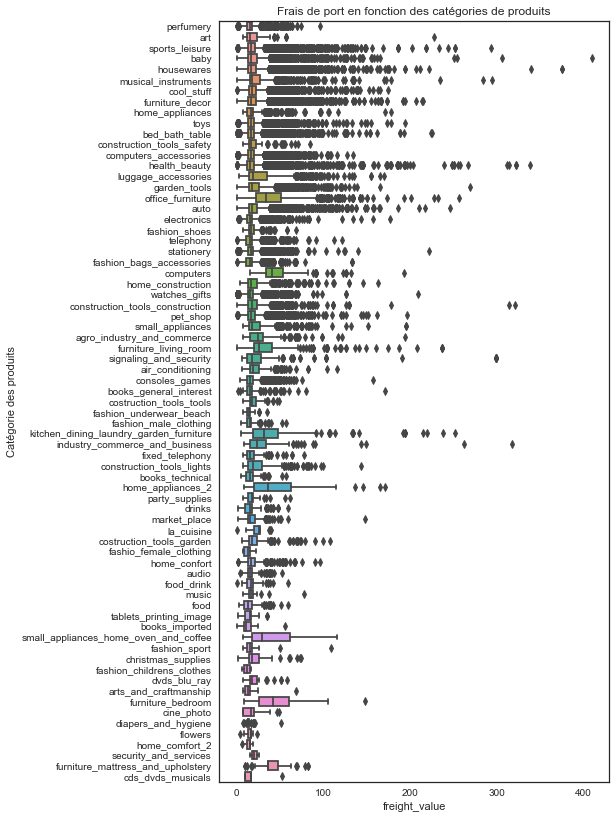

In [175]:
plt.figure(figsize=(7, 14))
sns.boxplot(x="freight_value", y="product_category_name_english", data=df_prod_orders)
plt.ylabel("Catégorie des produits")
plt.title("Frais de port en fonction des catégories de produits")
plt.show()

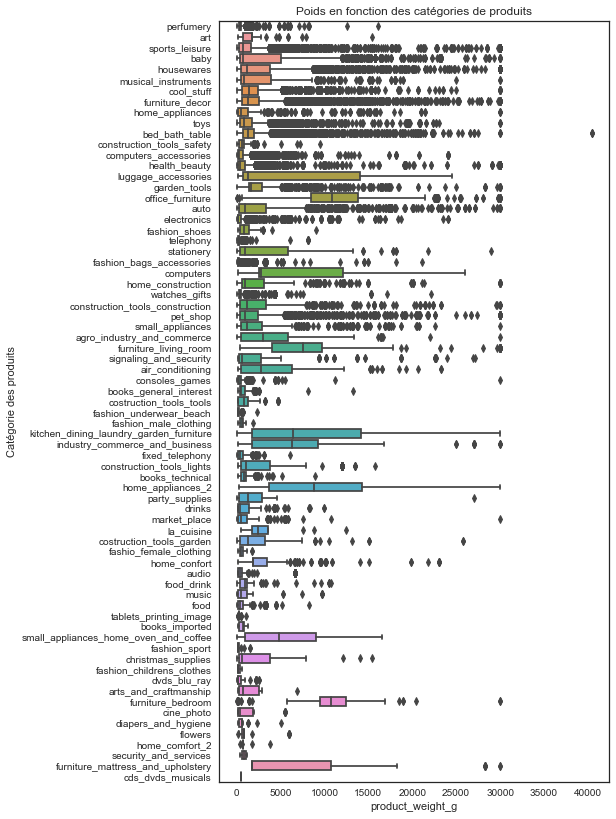

In [176]:
plt.figure(figsize=(7, 14))
sns.boxplot(x="product_weight_g", y="product_category_name_english", data=df_prod_orders)
plt.ylabel("Catégorie des produits")
plt.title("Poids en fonction des catégories de produits")
plt.show()

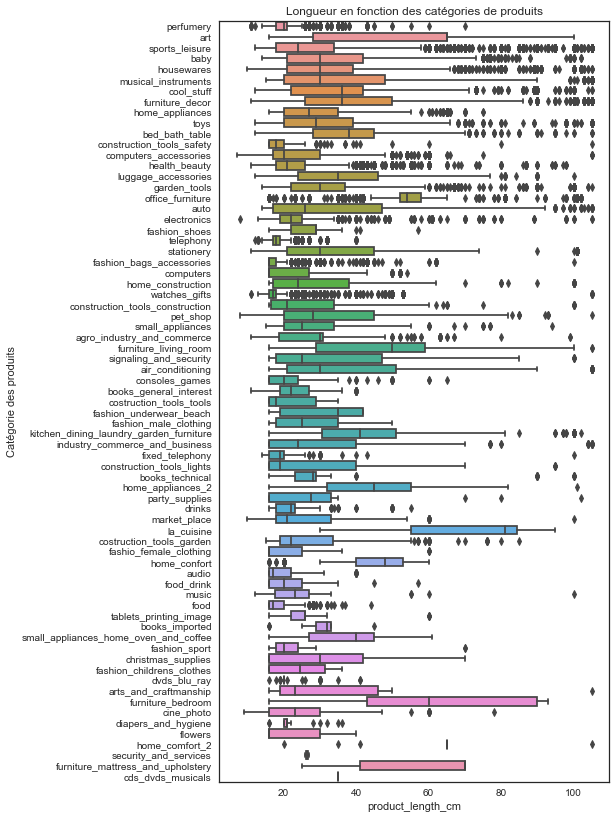

In [177]:
plt.figure(figsize=(7, 14))
sns.boxplot(x="product_length_cm", y="product_category_name_english", data=df_prod_orders)
plt.ylabel("Catégorie des produits")
plt.title("Longueur en fonction des catégories de produits")
plt.show()

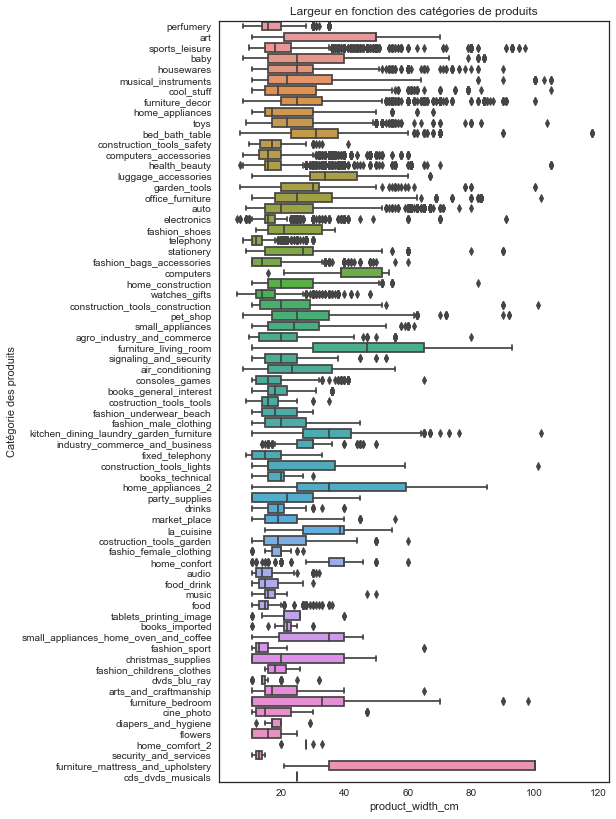

In [178]:
plt.figure(figsize=(7, 14))
sns.boxplot(x="product_width_cm", y="product_category_name_english", data=df_prod_orders)
plt.ylabel("Catégorie des produits")
plt.title("Largeur en fonction des catégories de produits")
plt.show()

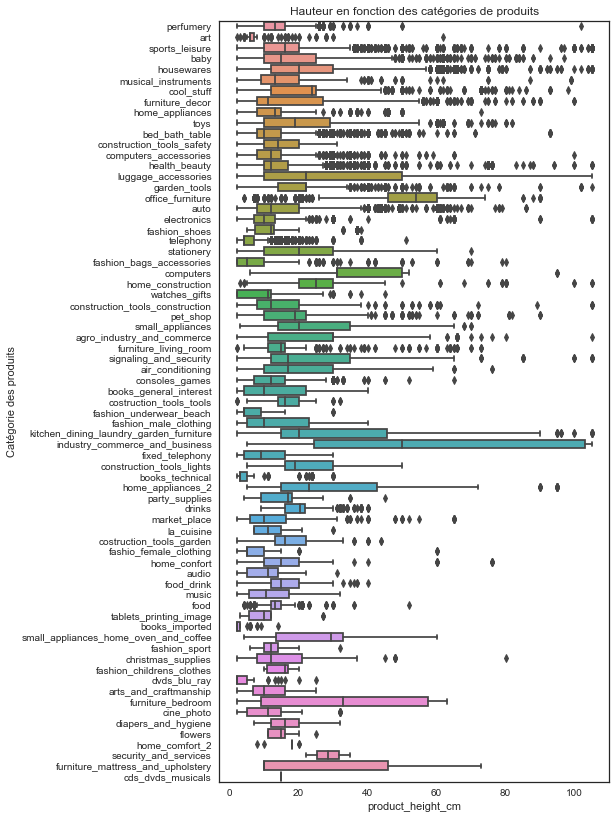

In [179]:
plt.figure(figsize=(7, 14))
sns.boxplot(x="product_height_cm", y="product_category_name_english", data=df_prod_orders)
plt.ylabel("Catégorie des produits")
plt.title("Hauteur en fonction des catégories de produits")
plt.show()

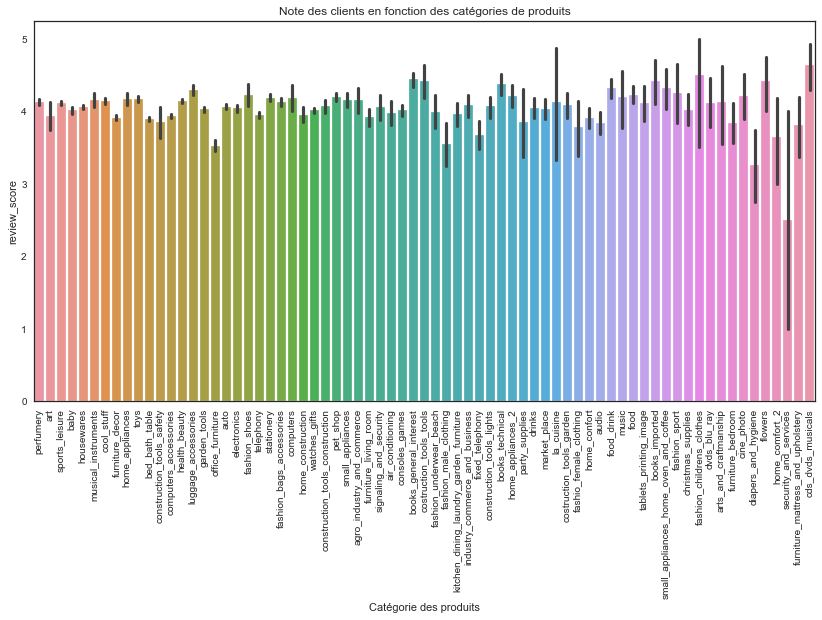

In [180]:
plt.figure(figsize=(14, 7))
sns.barplot(x="product_category_name_english", y="review_score", data=df_prod_orders)
plt.xlabel("Catégorie des produits")
plt.xticks(rotation=90)
plt.title("Note des clients en fonction des catégories de produits")
plt.show()

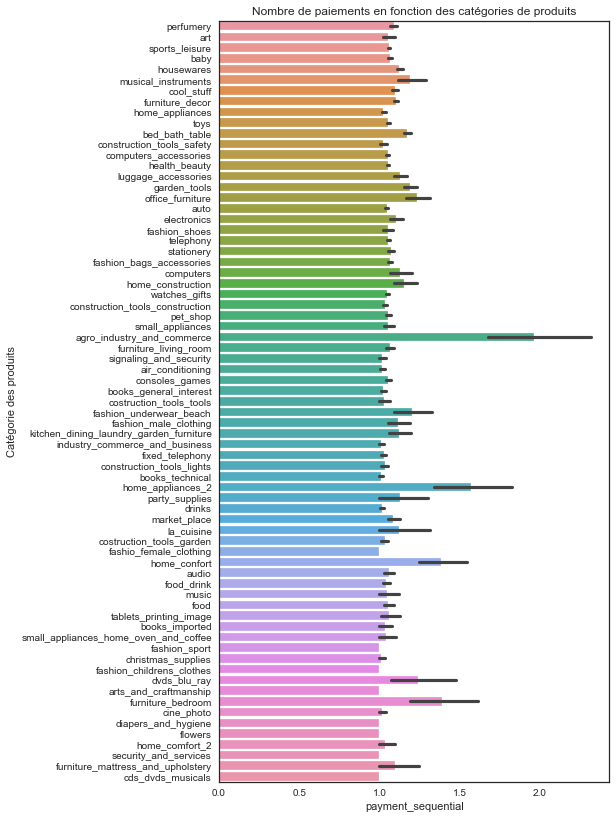

In [181]:
plt.figure(figsize=(7, 14))
sns.barplot(x="payment_sequential", y="product_category_name_english", data=df_prod_orders)
plt.ylabel("Catégorie des produits")
plt.title("Nombre de paiements en fonction des catégories de produits")
plt.show()

In [182]:
# Association between customers and orders
# In order to calculate Frequency and Recency
df = pd.merge(df_customers,
              df_orders,
              left_on="customer_id",
              right_on="customer_id",
              how="right")
df.drop_duplicates(subset="customer_id",
                   inplace=True)

In [183]:
df.columns

Index(['customer_id', 'customer_unique_id', 'customer_city',
       'customer_latitude', 'customer_longitude', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'order_item_id',
       'product_id', 'seller_id', 'shipping_limit_date', 'price',
       'freight_value'],
      dtype='object')

In [184]:
df_orders_payments = pd.read_csv("olist_order_payments_dataset.csv")

In [185]:
df = pd.merge(df, df_orders_payments, on="order_id")

In [186]:
df.columns

Index(['customer_id', 'customer_unique_id', 'customer_city',
       'customer_latitude', 'customer_longitude', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'payment_sequential_x',
       'payment_type_x', 'payment_installments_x', 'payment_value_x',
       'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value', 'payment_sequential_y',
       'payment_type_y', 'payment_installments_y', 'payment_value_y'],
      dtype='object')

In [187]:
# Association between customers, orders and orders payments
# In order to calculate MonetaryValue
df = pd.merge(df, df_orders_payments, left_on="order_id",
              right_on="order_id", how="right")

In [188]:
# Transformation timestamps into datetime
time = ["order_purchase_timestamp", "order_approved_at",
        "order_delivered_carrier_date", "order_delivered_customer_date",
        "order_estimated_delivery_date"]

for cols in time:
    df[cols] = pd.to_datetime(df[cols],
                              format="%Y-%m-%d", errors="ignore")

In [189]:
snapshot_date = max(df.order_purchase_timestamp) + datetime.timedelta(days=1)

In [190]:
df.columns

Index(['customer_id', 'customer_unique_id', 'customer_city',
       'customer_latitude', 'customer_longitude', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'payment_sequential_x',
       'payment_type_x', 'payment_installments_x', 'payment_value_x',
       'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value', 'payment_sequential_y',
       'payment_type_y', 'payment_installments_y', 'payment_value_y',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value'],
      dtype='object')

In [191]:
# Creation of RFM segmentation
rfm_custom = df.groupby("customer_unique_id").agg({
    "order_purchase_timestamp" : lambda x: (snapshot_date - x.max()).days,
    "order_id" : 'count',
    "payment_value" : "mean"
})
rfm_custom.columns = ["Recency", "Frequency", "MonetaryValue"]
data = rfm_custom.copy().reset_index()

In [192]:
# Calculation of scores with the help of quartiles
# Except for the frequency
data['r_quartile'] = pd.qcut(data['Recency'], 4, ['1', '2', '3', '4'])
data['f_bins'] = pd.cut(data['Frequency'], 2, labels=['2', '1'])
data['m_quartile'] = pd.qcut(data['MonetaryValue'], 4, ['4', '3', '2', '1'])

In [193]:
# Creation of RFM Score with the concatenation of
# R, F & M quartile/bins
data['RFM_Score'] = data["r_quartile"].astype(str) \
                    + data["f_bins"].astype(str) \
                    + data["m_quartile"].astype(str)
data.sort_values("RFM_Score", ascending=True)

,customer_unique_id,Recency,Frequency,MonetaryValue,r_quartile,f_bins,m_quartile,RFM_Score
44976,77a63731fc358f68a5ce26211fc340a8,96,1,566.09,1,2,1,121
85965,e4c2432a8a9263a10cb7175ee5098529,136,1,294.80,1,2,1,121
79140,d280c55bb8f45e367a7f24151bc99fdd,98,1,2345.03,1,2,1,121
5503,0ea5a9c83f775d940ef00bbbcef347cf,127,1,180.85,1,2,1,121
55239,934157f44075d9ca396f27f72c99a338,128,1,333.45,1,2,1,121
...,...,...,...,...,...,...,...,...
35002,5cd49b710f13c8714bf78f4d56b676b5,471,1,25.78,4,2,4,424
34973,5cbf577aa643b800590b5b2db36aa400,590,1,45.86,4,2,4,424
34971,5cbcdc54ce6ed0a050d4e3ab38b1abb4,506,1,31.84,4,2,4,424
85299,e2fd4c6781935ad89e8781943f266cfd,512,1,60.09,4,2,4,424


On remarque que la fréquence d'achat est le plus souvent de 1. Le choix a donc été fait de faire une binarisation de cette donnée en 1 (un achat) et 2 (plus d'un achat). Ce problème sur la fréquence d'achat va se répercuter sur la récence. Enfin, pour le montant dépensé, les calculs ont pu être fait classiquement. La séparation a été réalisée sur la base des quartiles.

Une fois la discrétisation des variables R, F et M réalisée, on crée un score qui correspond à la concaténation de ces trois indices. Ainsi, on obtient une segmentation RFM composée de 32 segments (4 x 2 x 4).

#### c. Analyse de la segmentation RFM

In [194]:
# Describe statistics
data.describe()

,Recency,Frequency,MonetaryValue
count,96095.000000,96095.000000,96095.000000
mean,290.107727,1.235548,158.636702
std,153.607874,5.292377,220.154652
min,1.000000,1.000000,0.000000
25%,166.000000,1.000000,60.235000
50%,271.000000,1.000000,103.420000
75%,400.000000,1.000000,175.080000
max,773.000000,841.000000,13664.080000


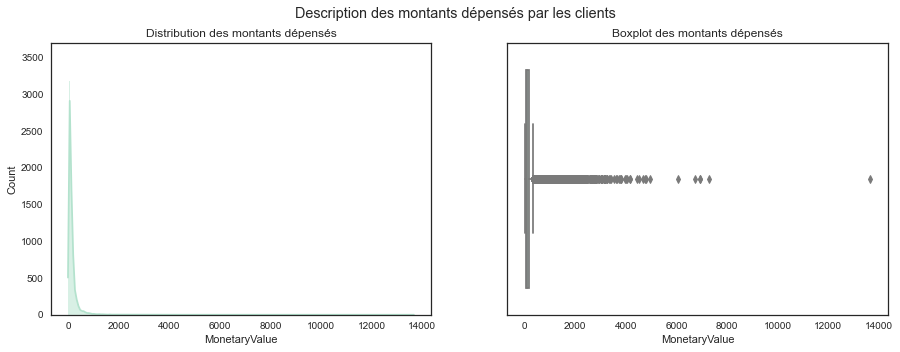

In [195]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Description des montants dépensés par les clients')

sns.histplot(ax=axes[0], x="MonetaryValue", data=data, kde=True)
axes[0].set_title("Distribution des montants dépensés")

sns.boxplot(ax=axes[1], x="MonetaryValue", data=data)
axes[1].set_title("Boxplot des montants dépensés")

plt.show()

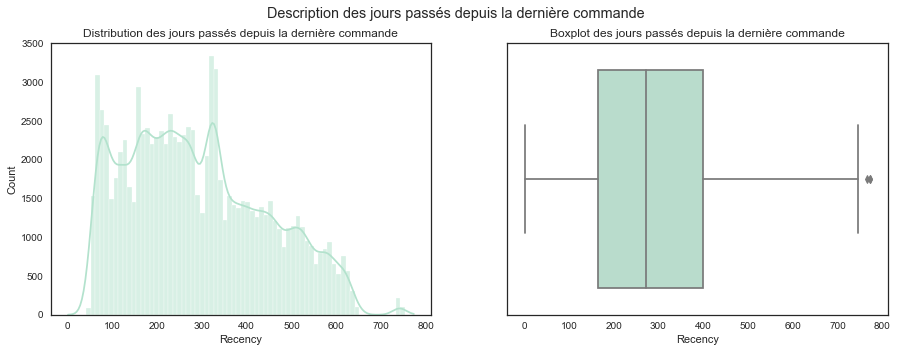

In [196]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Description des jours passés depuis la dernière commande')

sns.histplot(ax=axes[0], x="Recency", data=data, kde=True)
axes[0].set_title("Distribution des jours passés depuis la dernière commande")

sns.boxplot(ax=axes[1], x="Recency", data=data)
axes[1].set_title("Boxplot des jours passés depuis la dernière commande")

plt.show()

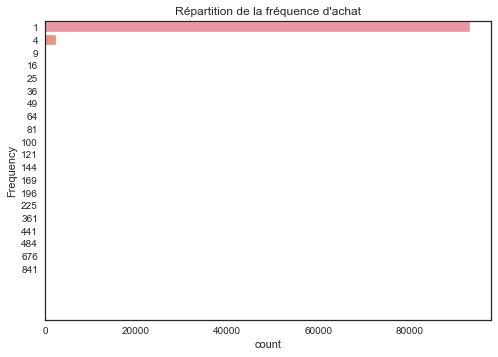

In [197]:
sns.countplot(y="Frequency", data=data)
plt.ylim(23)
plt.title("Répartition de la fréquence d'achat")

plt.show()

##### Conclusion

La fréquence et la récence ne semblent pas être très discriminants. En effet, la plupart des clients réalise un seul achat. De même, il est difficile de savoir s'ils reviennent régulièrement acheter donc la récence est très variable. Les sommes dépensées atteignent un maximum de 14.000 Réaux.

En inspectant le fonctionnement du site, il s'avère que l'on peut commander sans avoir besoin de créer un compte. On ne peut donc pas savoir si une personne commande plusieurs fois et obtenir les informations nécessaires. Il pourrait être intéressant d'instaurer un système de compte pour obtenir des informations plus stables sur la récence et la fréquence. A défaut, un système de cookies pouvant "tracker" (tout en respectant les législations en vigueur) peut être une solution permettant de remédier à ce problème.

In [198]:
del df_orders_payments
del rfm_custom

In [199]:
gc.collect()

4760

In [200]:
data.set_index("customer_unique_id", inplace=True)

In [201]:
data.to_csv("data_segmentation_rfm.csv")

### 2. Ajout de variables supplémentaires

On va créer de nouvelles variables que l'on va ajouter pour pouvoir obtenir une segmentation plus fine. Parmi ces variables, on va ajouter le nombre de jours entre la commande (order_approved_at) et la réception de cette dernière, la distance entre le client et le vendeur, l'avis du client et la catégorie de produits commandée.

In [202]:
data.reset_index(inplace=True)

In [203]:
from haversine import haversine_vector

In [204]:
df_sellers = pd.read_csv("olist_sellers_dataset.csv")

In [205]:
df_sellers = pd.merge(df_geo, df_sellers,
                        right_on=["seller_zip_code_prefix",
                                  "seller_city",
                                  "seller_state"],
                        left_on=["geolocation_zip_code_prefix",
                                 "geolocation_city",
                                 "geolocation_state"],
                        how="right")
df_sellers.drop(["geolocation_zip_code_prefix",
                 "geolocation_city",
                 "geolocation_state"], axis=1, inplace=True)
df_sellers = df_sellers[['seller_id',
                         "geolocation_lat",
                         "geolocation_lng"]]
df_sellers.columns = ["seller_id",
                      "seller_latitude",
                      "seller_longitude"]

In [206]:
df_sellers.drop_duplicates(subset="seller_id", inplace=True)

In [207]:
df_items = pd.read_csv("olist_order_items_dataset.csv")

In [208]:
df_items = pd.merge(df_orders, df_items, on="order_id", how="left")

In [209]:
df_items = pd.merge(df_items, df_customers, on="customer_id", how="left")

In [210]:
#df_items = pd.merge(df_sellers, df_items, on="seller_id_x", how="left")

In [211]:
df_items.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'order_item_id_x', 'product_id_x',
       'seller_id_x', 'shipping_limit_date_x', 'price_x', 'freight_value_x',
       'order_item_id_y', 'product_id_y', 'seller_id_y',
       'shipping_limit_date_y', 'price_y', 'freight_value_y',
       'customer_unique_id', 'customer_city', 'customer_latitude',
       'customer_longitude'],
      dtype='object')

In [212]:
df_items.dropna(subset=["customer_city"], inplace=True)

In [213]:
df_items = df_items[["customer_unique_id",
                     "product_id_x"]]
data = pd.merge(data, df_items,
                on="customer_unique_id",
                how="left")

#### a. Informations sur le type de produits commandés

In [214]:
df_products = pd.read_csv("olist_products_dataset.csv")
df_translation = pd.read_csv("product_category_name_translation.csv")
df_products = pd.merge(df_products,
                       df_translation,
                       on="product_category_name")
df_products = df_products[["product_id",
                           "product_category_name_english"]]
df_products.rename(columns={"product_category_name_english" : "product_category_name"}, 
                   inplace=True)
data.rename(columns={"product_id_x":"product_id"},inplace=True)

In [215]:
data = pd.merge(data, df_products, on="product_id", how="left")
data.drop("product_id", axis=1, inplace=True)

#### b. Informations sur les avis clients

In [216]:
df_reviews = pd.read_csv("olist_order_reviews_dataset.csv")

In [217]:
df_reviews.drop(["review_id", "review_creation_date",
                 "review_answer_timestamp"],
                axis=1,
                inplace=True)

In [218]:
df_reviews["review_score"] = df_reviews["review_score"].astype("int32")

In [219]:
df_orders = pd.read_csv("olist_orders_dataset.csv")

In [220]:
df_orders.drop(["order_purchase_timestamp",
                "order_delivered_carrier_date"], axis=1, inplace=True)
cols_time = ["order_approved_at",
             "order_delivered_customer_date",
             "order_estimated_delivery_date"]

for cols in cols_time:
    df_orders[cols] = pd.to_datetime(df_orders[cols],
                                     format="%Y-%m-%d",
                                     errors="ignore")

In [221]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_approved_at              99281 non-null  datetime64[ns]
 4   order_delivered_customer_date  96476 non-null  datetime64[ns]
 5   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](3), object(3)
memory usage: 4.6+ MB


#### c. Calcul entre le nombre de jours entre la commande et la réception réel et estimé

In [222]:
df_orders["nb_days_before_delivered"] = df_orders["order_delivered_customer_date"] \
                                        - df_orders["order_approved_at"]
df_orders["nb_days_before_delivered_estimation"] = df_orders["order_estimated_delivery_date"] \
                                                   - df_orders["order_approved_at"]

cols_var = ["nb_days_before_delivered",
            "nb_days_before_delivered_estimation"]

for cols in cols_var:
    df_orders[cols] = df_orders[cols].dt.days

df_orders.drop(["order_approved_at",
                "order_delivered_customer_date",
                "order_estimated_delivery_date"], axis=1, inplace=True)

#### d. Création d'un dataframe unique : assemblage des différentes variables

In [223]:
df_customers_orders = pd.merge(df_customers,
                               df_orders,
                               on="customer_id",
                               how="left")

In [224]:
df_customers_orders = pd.merge(df_customers_orders,
                               df_reviews,
                               on="order_id",
                               how="left")

In [225]:
df_customers_orders.drop(["order_id"], axis=1, inplace=True)

In [226]:
df_customers_orders.head()

,customer_id,customer_unique_id,customer_city,customer_latitude,customer_longitude,order_status,nb_days_before_delivered,nb_days_before_delivered_estimation,review_score,review_comment_title,review_comment_message
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,-20.509897,-47.397866,delivered,8.0,19.0,4.0,NaN,NaN
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,sao bernardo do campo,-23.726853,-46.545746,delivered,16.0,24.0,5.0,NaN,NaN
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,sao paulo,-23.527788,-46.660310,delivered,25.0,23.0,5.0,NaN,NaN
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,mogi das cruzes,-23.496930,-46.185352,delivered,14.0,27.0,5.0,NaN,NaN
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,campinas,-22.987222,-47.151073,delivered,11.0,16.0,5.0,a melhor nota,O baratheon è esxelente Amo adoro o baratheon


In [227]:
df_customers_orders = df_customers_orders.groupby("customer_unique_id").mean()
df_customers_orders.reset_index(inplace=True)

In [228]:
data = pd.merge(data, df_customers_orders, on="customer_unique_id", how="left")

In [229]:
data = pd.merge(df_customers, data, on="customer_unique_id", how="right")

In [230]:
data.drop_duplicates(subset="customer_unique_id", inplace=True)

In [231]:
data.drop(["customer_id",
           "customer_longitude_x",
           "customer_latitude_x",
           "customer_longitude_y",
           "customer_latitude_y"], axis=1, inplace=True)
data.set_index("customer_unique_id",
               inplace=True)

In [232]:
data = data.loc[data["nb_days_before_delivered"] > 0]
data = data.loc[data["nb_days_before_delivered_estimation"] > 0]

In [233]:
data.dropna()

,customer_city,Recency,Frequency,MonetaryValue,r_quartile,f_bins,m_quartile,RFM_Score,product_category_name,nb_days_before_delivered,nb_days_before_delivered_estimation,review_score
customer_unique_id,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,cajamar,161,1,141.90,1,2,2,122,bed_bath_table,6.0,10.0,5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,osasco,164,1,27.19,1,2,4,124,health_beauty,2.0,7.0,4.0
0000f46a3911fa3c0805444483337064,sao jose,586,1,86.22,4,2,3,423,stationery,25.0,27.0,3.0
0000f6ccb0745a6a4b88665a16c9f078,belem,370,1,43.62,3,2,4,324,telephony,20.0,31.0,4.0
0004aac84e0df4da2b147fca70cf8255,sorocaba,337,1,196.89,3,2,1,321,telephony,13.0,20.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,sanharo,496,1,2067.42,4,2,1,421,health_beauty,27.0,54.0,5.0
fffea47cd6d3cc0a88bd621562a9d061,feira de santana,311,1,84.58,3,2,3,323,baby,30.0,32.0,4.0
ffff371b4d645b6ecea244b27531430a,sinop,618,1,112.46,4,2,2,422,auto,14.0,44.0,5.0


In [234]:
data_ok = data.copy()

### 3. Analyse des données clients

In [235]:
# Descriptive statistics
data.describe()

,Recency,Frequency,MonetaryValue,nb_days_before_delivered,nb_days_before_delivered_estimation,review_score
count,93019.000000,93019.000000,93019.000000,93019.000000,93019.000000,92399.000000
mean,288.698707,1.225954,157.655685,11.681947,22.865565,4.154203
std,152.734592,4.574859,217.656925,9.550647,8.744014,1.284523
min,50.000000,1.000000,1.737500,1.000000,1.000000,1.000000
25%,165.000000,1.000000,60.220000,6.000000,17.000000,4.000000
50%,270.000000,1.000000,103.280000,9.000000,22.000000,5.000000
75%,398.000000,1.000000,174.500000,15.000000,28.000000,5.000000
max,745.000000,676.000000,13664.080000,208.000000,153.000000,5.000000


#### a. Analyses univariées des variables utilisées pour la segmentation

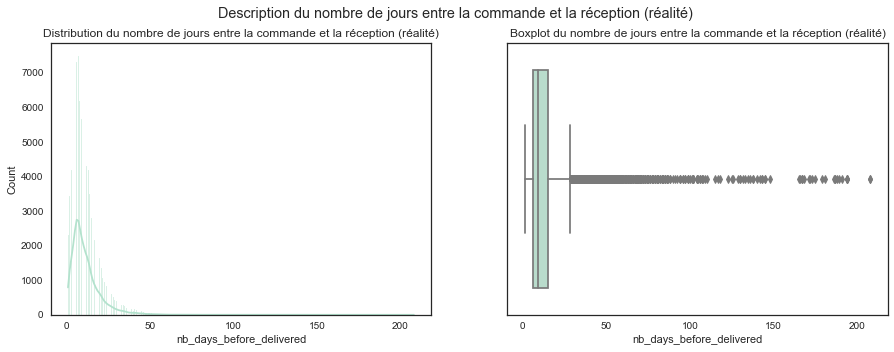

In [236]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Description du nombre de jours entre la commande et la réception (réalité)')

sns.histplot(ax=axes[0], x="nb_days_before_delivered", data=data, kde=True)
axes[0].set_title("Distribution du nombre de jours entre la commande et la réception (réalité)")

sns.boxplot(ax=axes[1], x="nb_days_before_delivered", data=data)
axes[1].set_title("Boxplot du nombre de jours entre la commande et la réception (réalité)")

plt.show()

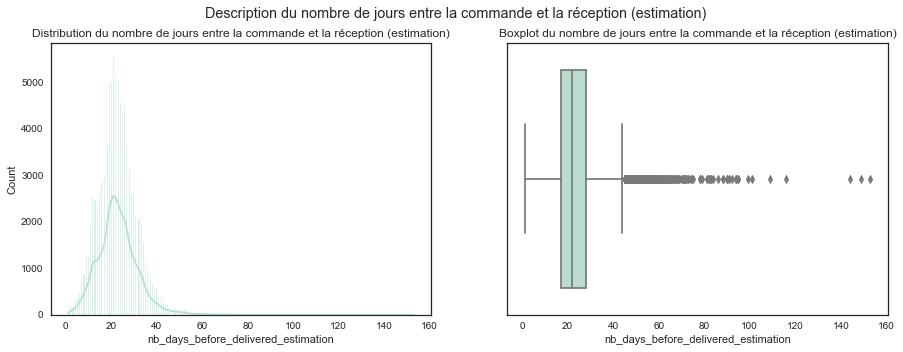

In [237]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Description du nombre de jours entre la commande et la réception (estimation)')

sns.histplot(ax=axes[0], x="nb_days_before_delivered_estimation", data=data, kde=True)
axes[0].set_title("Distribution du nombre de jours entre la commande et la réception (estimation)")

sns.boxplot(ax=axes[1], x="nb_days_before_delivered_estimation", data=data)
axes[1].set_title("Boxplot du nombre de jours entre la commande et la réception (estimation)")

plt.show()

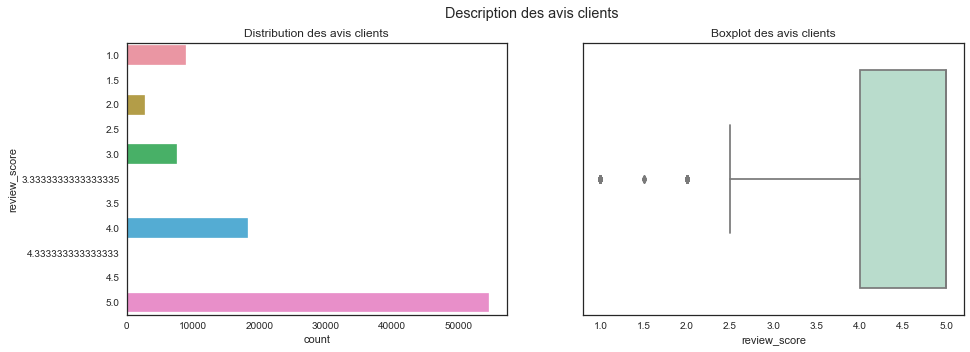

In [238]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=False)
fig.suptitle('Description des avis clients')

sns.countplot(ax=axes[0], y="review_score", data=data)
axes[0].set_title("Distribution des avis clients")

sns.boxplot(ax=axes[1], x="review_score", data=data)
axes[1].set_title("Boxplot des avis clients")

plt.show()

In [239]:
data.drop("nb_days_before_delivered_estimation", axis=1, inplace=True)
data.to_csv("data_clustering_complete.csv")

_____________________________________________________________________

## Création d'un dataset restreint

In [240]:
len(data.loc[data["Frequency"] != 1])

2754

On remarque que l'on a 2754 clients dans notre jeu de données dont la fréquence d'achats est différent de 0. On va donc se servir de ces clients et sélectionner l'équivalent de 40% de clients ayant effectué un achat. Ainsi la fréquence et la récence pourront être exploités par la suite car elles seront plus discriminantes.

In [241]:
freq_1 = data.loc[data["Frequency"] == 1]

In [242]:
freq_1= freq_1.sample(frac=0.4)

In [243]:
df = data.loc[data["Frequency"] != 1]

In [244]:
df = df.append(freq_1)

In [245]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38860 entries, 000e309254ab1fc5ba99dd469d36bdb4 to 202a17812bf14c4879aa314899918c86
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   customer_city             38860 non-null  object  
 1   Recency                   38860 non-null  int64   
 2   Frequency                 38860 non-null  int64   
 3   MonetaryValue             38860 non-null  float64 
 4   r_quartile                38860 non-null  category
 5   f_bins                    38860 non-null  category
 6   m_quartile                38860 non-null  category
 7   RFM_Score                 38860 non-null  object  
 8   product_category_name     38293 non-null  object  
 9   nb_days_before_delivered  38860 non-null  float64 
 10  review_score              38585 non-null  float64 
dtypes: category(3), float64(3), int64(2), object(3)
memory usage: 2.8+ MB


### Analyses statistiques

In [246]:
df.reset_index(inplace=True)

In [247]:
df.describe()

,Recency,Frequency,MonetaryValue,nb_days_before_delivered,review_score
count,38860.000000,38860.000000,38860.00000,38860.000000,38585.00000
mean,289.258441,1.540865,155.08889,11.675244,4.15928
std,152.814264,7.066037,222.94382,9.374618,1.27967
min,50.000000,1.000000,1.73750,1.000000,1.00000
25%,166.000000,1.000000,57.31500,6.000000,4.00000
50%,270.000000,1.000000,99.90000,9.000000,5.00000
75%,399.000000,1.000000,172.03250,15.000000,5.00000
max,745.000000,676.000000,13664.08000,208.000000,5.00000


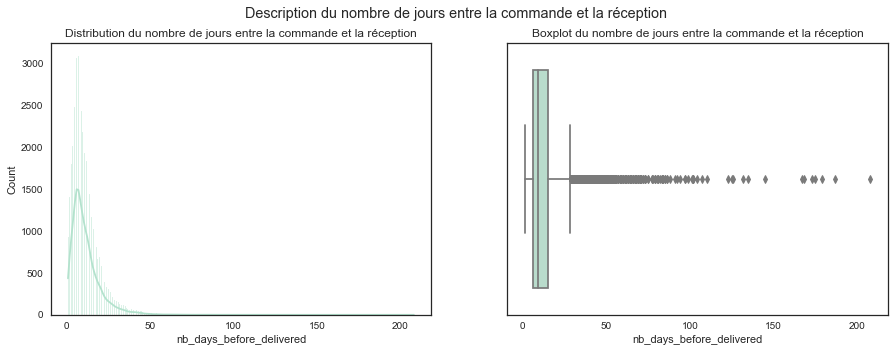

In [248]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Description du nombre de jours entre la commande et la réception')

sns.histplot(ax=axes[0], x="nb_days_before_delivered", data=df, kde=True)
axes[0].set_title("Distribution du nombre de jours entre la commande et la réception")

sns.boxplot(ax=axes[1], x="nb_days_before_delivered", data=df)
axes[1].set_title("Boxplot du nombre de jours entre la commande et la réception")

plt.show()

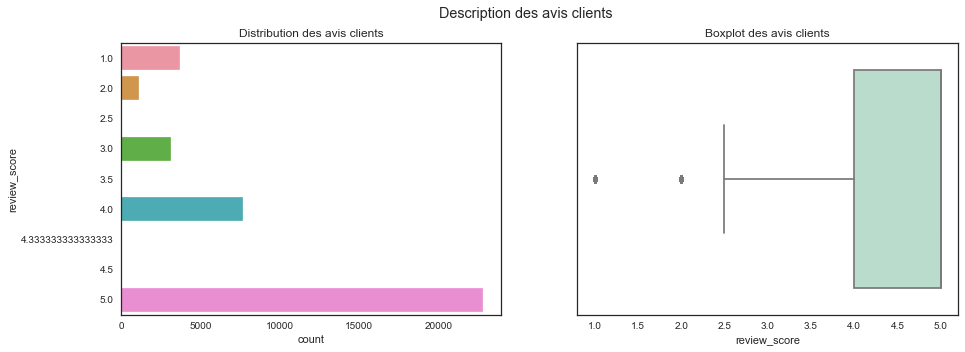

In [249]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=False)
fig.suptitle('Description des avis clients')

sns.countplot(ax=axes[0], y="review_score", data=df)
axes[0].set_title("Distribution des avis clients")

sns.boxplot(ax=axes[1], x="review_score", data=df)
axes[1].set_title("Boxplot des avis clients")

plt.show()

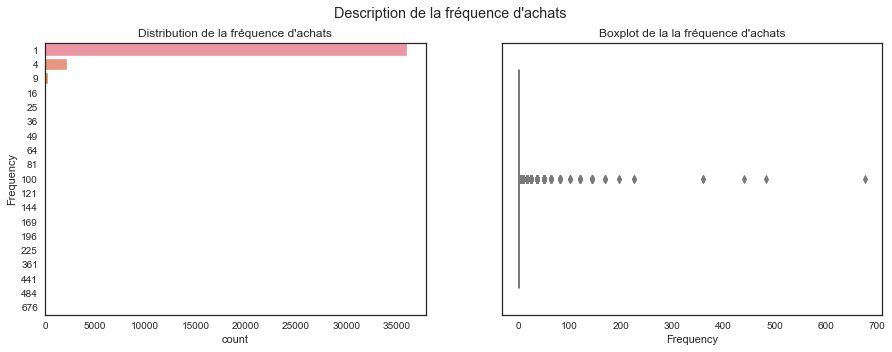

In [250]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("Description de la fréquence d\'achats")

sns.countplot(ax=axes[0], y="Frequency", data=df)
axes[0].set_title("Distribution de la fréquence d\'achats")

sns.boxplot(ax=axes[1], x="Frequency", data=df)
axes[1].set_title("Boxplot de la la fréquence d\'achats")

plt.show()

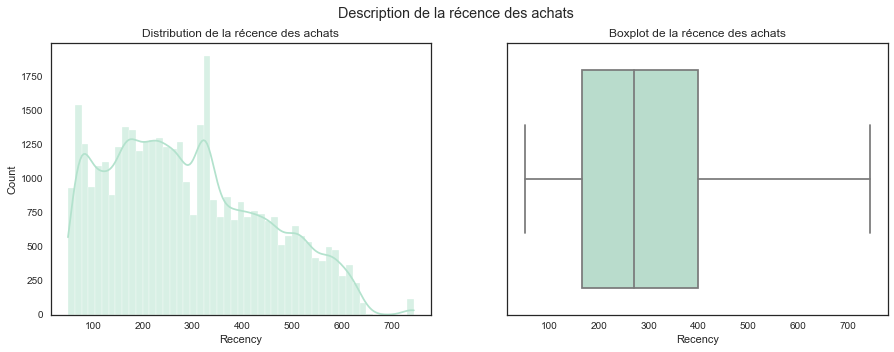

In [251]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle("Description de la récence des achats")

sns.histplot(ax=axes[0], x="Recency", data=df, kde=True)
axes[0].set_title("Distribution de la récence des achats")

sns.boxplot(ax=axes[1], x="Recency", data=df)
axes[1].set_title("Boxplot de la récence des achats")

plt.show()

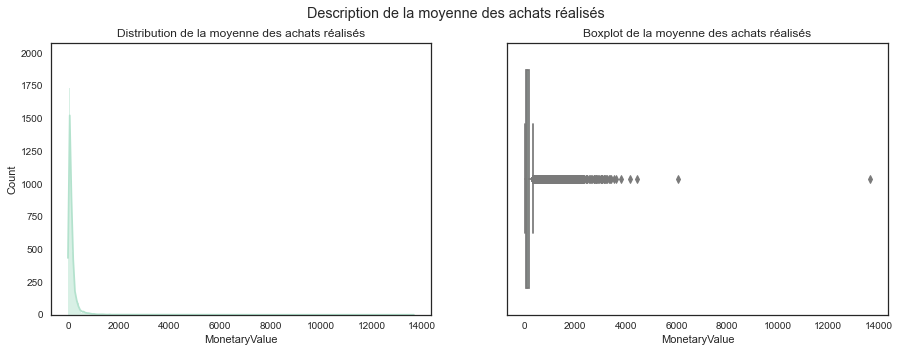

In [252]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle("Description de la moyenne des achats réalisés")

sns.histplot(ax=axes[0], x="MonetaryValue", data=df, kde=True)
axes[0].set_title("Distribution de la moyenne des achats réalisés")

sns.boxplot(ax=axes[1], x="MonetaryValue", data=df)
axes[1].set_title("Boxplot de la moyenne des achats réalisés")

plt.show()

### Segmentation RFM

In [253]:
df.set_index("customer_unique_id", inplace=True)
df.head(3)

,customer_city,Recency,Frequency,MonetaryValue,r_quartile,f_bins,m_quartile,RFM_Score,product_category_name,nb_days_before_delivered,review_score
customer_unique_id,,,,,,,,,,,
000e309254ab1fc5ba99dd469d36bdb4,valparaiso de goias,115,4,39.210,1,2,4,124,fashion_underwear_beach,14.0,3.0
0028a7d8db7b0247652509358ad8d755,valinhos,309,4,177.435,3,2,1,321,office_furniture,23.0,3.0
00324c9f4d710e7bac5c5ba679714430,paraiso do tocantins,483,4,54.890,4,2,4,424,housewares,12.0,5.0


In [254]:
# Calculation of scores with the help of quartiles
# Except for the frequency
data = pd.DataFrame()
data['r_quartile'] = pd.qcut(df['Recency'], 4, ['1', '2', '3', '4'])
data['f_bins'] = pd.cut(df['Frequency'], 4, labels=['4', '3','2', '1'])
data['m_quartile'] = pd.qcut(df['MonetaryValue'], 4, ['4', '3', '2', '1'])

In [255]:
# Creation of RFM Score with the concatenation of
# R, F & M quartile/bins
data['RFM_Score'] = data["r_quartile"].astype(str) \
                    + data["f_bins"].astype(str) \
                    + data["m_quartile"].astype(str)
data.sort_values("RFM_Score", ascending=True)

,r_quartile,f_bins,m_quartile,RFM_Score
customer_unique_id,,,,
301d1ce5a76b7e1bc47e5115bf5eb6ba,1,3,4,134
60dfa3ea01873e440cf35bccd839161f,1,4,1,141
c9c853a4ed4e4ea20c3d5313cc0a00fe,1,4,1,141
d9c3dd380cb915b94684aaf1c9f03362,1,4,1,141
1802d9b8b04e0f7bddb58ac2c7729c82,1,4,1,141
...,...,...,...,...
83d4f03665f228247540e9d373cbc65d,4,4,4,444
377860a7242c2e503c926b76ab6e0a65,4,4,4,444
e14dcbca72e57d7ee7ac43d9131b12b8,4,4,4,444


In [256]:
customers = pd.DataFrame()
customers["Recency"] = np.log1p(df['Recency'])
customers["Frequency"] = np.log1p(df["Frequency"])
customers["MonetaryValue"] = np.log1p(df["MonetaryValue"])
customers.reset_index(inplace=True)

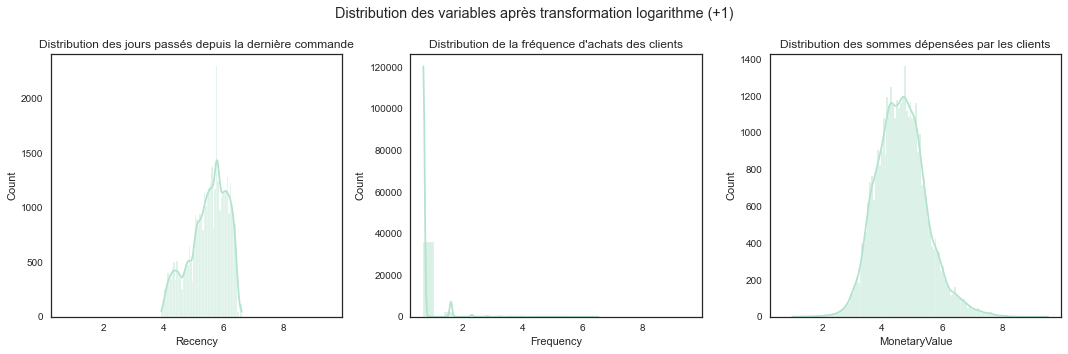

In [257]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)
fig.suptitle('Distribution des variables après transformation logarithme (+1)')

sns.histplot(ax=axes[0], x="Recency", data=customers, kde=True)
axes[0].set_title("Distribution des jours passés depuis la dernière commande")

sns.histplot(ax=axes[1], x="Frequency", data=customers, kde=True)
axes[1].set_title("Distribution de la fréquence d'achats des clients")

sns.histplot(ax=axes[2], x="MonetaryValue", data=customers, kde=True)
axes[2].set_title("Distribution des sommes dépensées par les clients")

plt.tight_layout()
plt.show()

In [258]:
customers.set_index("customer_unique_id", inplace=True)

In [259]:
scaler = StandardScaler()

scaler.fit(customers)
customers_normalized = scaler.transform(customers)

print("Mean:", customers_normalized.mean(axis=0).round(2))
print("Standard Deviation:", customers_normalized.std(axis=0).round(2))

Mean: [-0. -0. -0.]
Standard Deviation: [1. 1. 1.]


La transformation logarithmique a permis de modifier la forme de la distribution des variables Recency et MonetaryValue pour qu'elle soit proche d'une distribution normale. Cette modification permet de rendre les modèles d'apprentissage non-supervisé comme l'algorithme K-Means d'être plus performant.

Une seconde étape a été de standardiser nos données. Ainsi, nos données ont toutes une moyenne de 0 avec un écart-type de 1. Là, encore cette modification a pour but d'améliorer la performance de nos modèles d'apprentissage non-supervisé.

### Réduction de dimensions

La réduction de dimension a pour but de faciliter la visualisation de nos données en les ramenant dans un espace en 2 dimensions (même si dans ce cas, il aurait possible de les visualiser en 3 dimensions). De plus, la réduction de dimensions permet de diminuer le temps de calcul des algorithmes de clustering.

In [260]:
n_comp = 2
pca = PCA(n_components=n_comp)
features = customers.columns
data_pca = pca.fit_transform(customers_normalized)
pcs = pca.components_

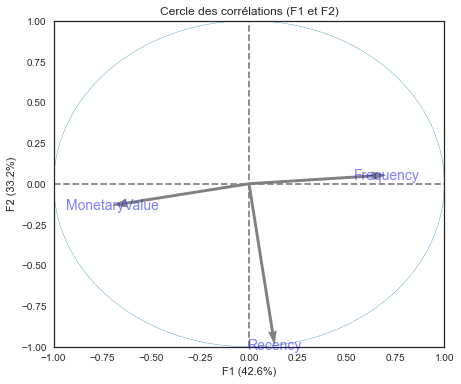

In [261]:
display_circles(pcs, n_comp, pca, [(0, 1)], labels=np.array(features))

### 2. Modélisation : k-means

Une fois les étapes de pré-traitement réalisés, on va pouvoir passer à la modélisation. On va utiliser un algorithme K-Means qui se base sur des calculs de distance entre les points de notre jeu de données et un point nommé centroïde. Il est possible d'entrer les coordonnées de ce centroïde. Dans notre situation, on ne possède pas de contrainte sur le placement de ces centroïdes, on va donc laisser ce paramètre s'initialiser aléatoirement. En revanche, on va chercher à déterminer le nombre de clusters (le K du K-Means). Pour cela, on s'intéresse à l'évolution des distorsions avec la "méthode du coude" (Elbow Method).

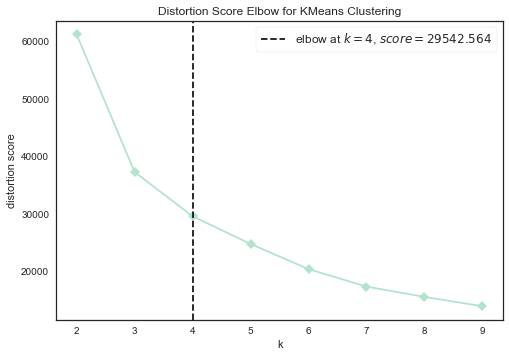

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [262]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10), timings=False)
visualizer.fit(data_pca)
visualizer.show()

Selon la méthode du coude, le nombre de cluster idéal est de 4. On va donc entraîner notre modèle avec ce paramètre.

In [263]:
sns.set_palette("Pastel2")
sns.set_style("ticks")

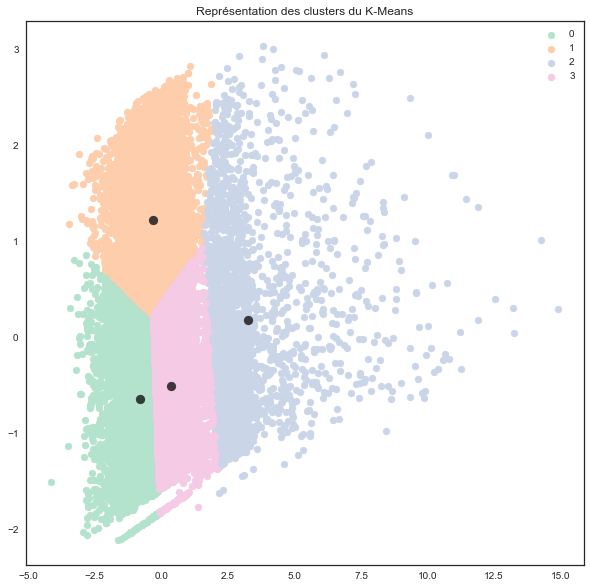

In [264]:
# Fitting KMeans
km = KMeans(n_clusters=4, random_state=42)

# Prediction
label = km.fit_predict(data_pca)
centroids = km.cluster_centers_
u_labels = np.unique(label)

# Graphical representation
plt.figure(figsize=(10, 10))
for i in u_labels:
    plt.scatter(data_pca[label==i, 0], data_pca[label==i, 1], label = i)
plt.scatter(centroids[:, 0], centroids[:,1], s=80, alpha=0.8, color='k')
plt.legend()
plt.title('Représentation des clusters du K-Means')
plt.show()

#### a. Description des clusters obtenus avec le modèle

In [265]:
df["Cluster"] = km.labels_
df.groupby('Cluster').agg({
    'Recency' : "mean", 
    'Frequency' : "mean",
    'MonetaryValue': "mean"}).round(2)

,Recency,Frequency,MonetaryValue
Cluster,,,
0,352.83,1.00,303.14
1,120.86,1.04,140.45
2,313.54,9.70,41.77
3,367.86,1.08,71.34


In [266]:
df_normalized = pd.DataFrame(customers_normalized,
                             columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = df.index
df_normalized["Cluster"] = km.labels_

df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=["ID", "Cluster"],
                      value_vars=["Recency", "Frequency", "MonetaryValue"],
                      var_name="Attribute",
                      value_name="Value")

df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,000e309254ab1fc5ba99dd469d36bdb4,2,Recency,-1.226492
1,0028a7d8db7b0247652509358ad8d755,3,Recency,0.376640
2,00324c9f4d710e7bac5c5ba679714430,2,Recency,1.103221
3,0058f300f57d7b93c477a131a59b36c3,2,Recency,-0.258533
4,00986cafefb6e670cceca01694bda599,2,Recency,0.273488


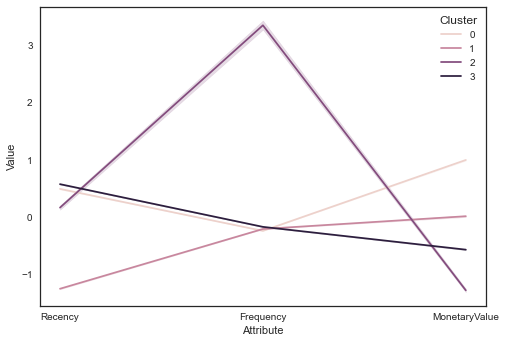

In [267]:
sns.lineplot("Attribute", "Value", hue="Cluster", data=df_nor_melt)
plt.show()

#### b. Evaluation du modèle

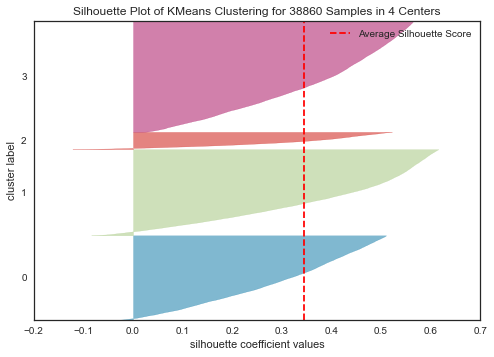

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 38860 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [268]:
visualizer = SilhouetteVisualizer(km, colors='yellowbrick')

visualizer.fit(data_pca)
visualizer.show()

In [269]:
print("Silhouette Score:", silhouette_score(data_pca, label))
print("Score de Davies-Bouldin:", davies_bouldin_score(data_pca, label))

Silhouette Score: 0.3449347576202838
Score de Davies-Bouldin: 0.9202200170356134


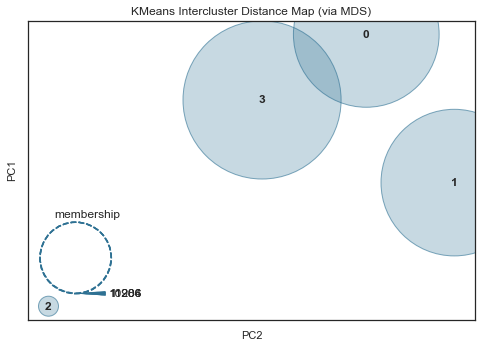

InterclusterDistance(ax=<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>,
                     estimator=KMeans(n_clusters=4, random_state=42))

In [270]:
intercluster_distance(KMeans(4, random_state=42), data_pca)

##### Conclusion

Trois de nos clusters semblent équilibrés et le dernier est plutôt faible. Ce cluster le plus petit est celui qui contient les clients ayant une fréquence d'achat supérieur à 2. Il s'agit donc des clients qui ont crée un compte et qui sont susceptibles de revenir régulièrement. Le reste des indices montre un clustering de bonne qualité. Cependant, la lecture des données ne permet de distinguer de véritables segmentations actionnables (outre les clients fidèles). On peut evisager d'affiner cette segmentation en y ajoutant des variables supplémentaires.

#### c. Stabilité de l'algorithme

On s'intéresse à la stabilité de notre algorithme pour déterminer les dates de maintenance de ce dernier.

In [271]:
data_ok.columns

Index(['customer_city', 'Recency', 'Frequency', 'MonetaryValue', 'r_quartile',
       'f_bins', 'm_quartile', 'RFM_Score', 'product_category_name',
       'nb_days_before_delivered', 'nb_days_before_delivered_estimation',
       'review_score'],
      dtype='object')

In [272]:
data_stability = pd.DataFrame()
data_stability["Recency"] = np.log1p(data_ok["Recency"])
data_stability["Frequency"] = np.log1p(data_ok["Frequency"])
data_stability["MonetaryValue"] = np.log1p(data_ok["MonetaryValue"])
data_stability["nb_days_before_delivered"] = np.log1p(data_ok["nb_days_before_delivered"])
#data_stability["distance_customer_seller"] = np.log1p(data_ok["distance_customer_seller"])

In [273]:
data_test_180d = data_stability.loc[data_ok["Recency"] < 180]

In [274]:
data_stability.columns

Index(['Recency', 'Frequency', 'MonetaryValue', 'nb_days_before_delivered'], dtype='object')

In [275]:
customers_stability = customers
customers_stability["Recency"] = customers_stability["Recency"].values \
                               - np.log1p(180)

In [276]:
customers_stability.head()

,Recency,Frequency,MonetaryValue
customer_unique_id,,,
000e309254ab1fc5ba99dd469d36bdb4,-0.444907,1.609438,3.694116
0028a7d8db7b0247652509358ad8d755,0.538075,1.609438,5.184224
00324c9f4d710e7bac5c5ba679714430,0.983588,1.609438,4.023385
0058f300f57d7b93c477a131a59b36c3,0.148610,1.609438,3.892024
00986cafefb6e670cceca01694bda599,0.474826,1.609438,3.539654


In [277]:
customers_test_stab = scaler.transform(customers_stability)
customers_test_stab = pca.transform(customers_test_stab)
label1 = model.predict(customers_test_stab)

In [278]:
stability = pd.DataFrame({"label_begin" : label1},
                         index=customers_stability.index)
stability.head(3)

,label_begin
customer_unique_id,
000e309254ab1fc5ba99dd469d36bdb4,2
0028a7d8db7b0247652509358ad8d755,2
00324c9f4d710e7bac5c5ba679714430,2


In [279]:
customers_stability["Recency"] = customers_stability["Recency"].values \
                                 + np.log1p(30)

In [280]:
customers_stability["Recency"] = customers_stability["Recency"].values \
                                + np.log1p(30)
customers_test_stab = scaler.transform(customers_stability)
customers_test_stab = pca.transform(customers_test_stab)
label2 = model.predict(customers_test_stab)
stability["label_30d"] = label2

In [281]:
customers_stability["Recency"] = customers_stability["Recency"].values \
                                + np.log1p(30)
customers_test_stab = scaler.transform(customers_stability)
customers_test_stab = pca.transform(customers_test_stab)
label3 = model.predict(customers_test_stab)
stability["label_60d"] = label3

In [282]:
customers_stability["Recency"] = customers_stability["Recency"].values \
                                + np.log1p(30)
customers_test_stab = scaler.transform(customers_stability)
customers_test_stab = pca.transform(customers_test_stab)
label4 = model.predict(customers_test_stab)
stability["label_90d"] = label4

In [283]:
customers_stability["Recency"] = customers_stability["Recency"].values \
                                + np.log1p(30)
customers_test_stab = scaler.transform(customers_stability)
customers_test_stab = pca.transform(customers_test_stab)
label5 = model.predict(customers_test_stab)
stability["label_120d"] = label5

In [284]:
customers_stability["Recency"] = customers_stability["Recency"].values \
                                + np.log1p(30)
customers_test_stab = scaler.transform(customers_stability)
customers_test_stab = pca.transform(customers_test_stab)
label6 = model.predict(customers_test_stab)
stability["label_150d"] = label6

In [285]:
customers_stability["Recency"] = customers_stability["Recency"].values \
                                + np.log1p(30)
customers_test_stab = scaler.transform(customers_stability)
customers_test_stab = pca.transform(customers_test_stab)
label7 = model.predict(customers_test_stab)
stability["label_180d"] = label7

In [286]:
stability.head(3)

,label_begin,label_30d,label_60d,label_90d,label_120d,label_150d,label_180d
customer_unique_id,,,,,,,
000e309254ab1fc5ba99dd469d36bdb4,2,5,8,3,3,3,3
0028a7d8db7b0247652509358ad8d755,2,8,3,3,3,3,3
00324c9f4d710e7bac5c5ba679714430,2,8,3,3,3,3,3


In [287]:
from sklearn.metrics import adjusted_rand_score

print("ARI à 1 mois :", \
      adjusted_rand_score(stability['label_begin'], \
                          stability["label_30d"]))
print("ARI à 2 mois :", \
      adjusted_rand_score(stability["label_begin"], \
                          stability["label_60d"]))
print("ARI à 3 mois :", \
      adjusted_rand_score(stability["label_begin"], \
                          stability["label_90d"]))
print("ARI à 4 mois :", \
      adjusted_rand_score(stability["label_begin"], \
                          stability["label_120d"]))
print("ARI à 5 mois :", \
      adjusted_rand_score(stability["label_begin"], \
                          stability["label_150d"]))
print("ARI à 6 mois :", \
      adjusted_rand_score(stability["label_begin"], \
                          stability["label_180d"]))

ARI à 1 mois : 0.026509149472440853
ARI à 2 mois : 0.22992485794806244
ARI à 3 mois : 0.600223519734932
ARI à 4 mois : 0.744859814448937
ARI à 5 mois : 0.8324882442389412
ARI à 6 mois : 0.915141090213812


La stabilité de notre modèle se dégrade très vite. Une maintenance mensuelle sera nécessaire pour pouvoir obtenir une segmentation qui ait encore du sens.

### 3. Modélisation : k-prototype

L'algorithme K-Prototype est un algorithme de la même famille que le K-Means. Cependant, le K-Prototype permet d'ajouter des variables catégorielles dans notre segmentation. On ajoute en plus des variables présentées dans le modèle précédents, la ville d'origine du client, l'avis moyen donné lors de ces commandes et le type de produits commandé.

On choisit de diviser notre échantillon en 4 clusters.

In [288]:
data_ok.drop(["r_quartile",
           "f_bins",
           "m_quartile",
           "RFM_Score"],
           axis=1, inplace=True)

In [289]:
data_ok.head()

,customer_city,Recency,Frequency,MonetaryValue,product_category_name,nb_days_before_delivered,nb_days_before_delivered_estimation,review_score
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,cajamar,161,1,141.90,bed_bath_table,6.0,10.0,5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,osasco,164,1,27.19,health_beauty,2.0,7.0,4.0
0000f46a3911fa3c0805444483337064,sao jose,586,1,86.22,stationery,25.0,27.0,3.0
0000f6ccb0745a6a4b88665a16c9f078,belem,370,1,43.62,telephony,20.0,31.0,4.0
0004aac84e0df4da2b147fca70cf8255,sorocaba,337,1,196.89,telephony,13.0,20.0,5.0


In [290]:
cols = data_ok.columns

for col in cols:
    if data_ok[col].dtypes == "float":
        data_ok[col] = np.log1p(data_ok[col].values)

In [291]:
cat_var = ["review_score", "customer_city", "product_category_name"]
num_var = ["Frequency", "Recency", "nb_days_before_delivered",
           "MonetaryValue"]

In [292]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing'))
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="median", fill_value="missing")),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
    ('cat', cat_pipe, cat_var),
    ('num', num_pipe, num_var)
])

In [294]:
data_normalized = preprocessor.fit_transform(data_ok)
data_normalized = pd.DataFrame(data_normalized, columns=["review_score",
                                                         "customer_city",
                                                         "product_category_name",
                                                         "Frequency",
                                                         "Recency",
                                                         "nb_days_before_delivered",
                                                         "MonetaryValue"])

In [295]:
for col in num_var:
    data_normalized[col] = data_normalized[col].astype("float32")

In [296]:
# Get the position of categorical columns
catColumnsPos = [data_normalized.columns.get_loc(col)\
                 for col in list(data_normalized.select_dtypes('object').columns)]
print('Categorical columns           : {}'.format(list(data_normalized.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns           : ['review_score', 'customer_city', 'product_category_name']
Categorical columns position  : [0, 1, 2]


In [297]:
# Convert datagram to matrix (help the kmodes module running the k-prototype clustering algorithm)
dfMatrix = data_normalized.to_numpy()

In [299]:
kprototype = KPrototypes(n_jobs=-1,
                         n_clusters=4,
                         init='Huang',
                         random_state=0)
kprototype.fit_predict(dfMatrix,
                       categorical=catColumnsPos)

In [ ]:
data_ok['cluster_id'] = kprototype.labels_